In [1]:
# Standard libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt
import time
import csv
import numpy as np
import os
import sys

# Add parent folder to sys.path for module imports
BASE_DIR = Path("..").resolve()
sys.path.append(str(BASE_DIR))

# Import our MoE model from optimization/moe.py
from optimization.moe import FFN_MoE

torch.manual_seed(0)
device = "cpu"  # PTQ is CPU-focused




In [2]:
DATA_DIR = Path("../data")
EXP_DIR = Path("../experiments")
MODEL_DIR = Path("../models")
EXP_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_set = datasets.MNIST(DATA_DIR, train=True, download=False, transform=transform)
test_set  = datasets.MNIST(DATA_DIR, train=False, download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)


In [3]:
# Load FP32 MoE model
model_fp32 = FFN_MoE()
model_path = MODEL_DIR / "sparse_moe_mnist.pth"
model_fp32.load_state_dict(torch.load(model_path, map_location="cpu"))
model_fp32.eval()
print(f"FP32 MoE model loaded from {model_path}")


FP32 MoE model loaded from ../models/sparse_moe_mnist.pth


In [4]:
def evaluate(model, loader):
    """
    Evaluate accuracy and measure average batch latency.
    """
    model.eval()
    correct = 0
    start = time.time()

    with torch.no_grad():
        for x, y in loader:
            logits, _, _, _ = model(x)
            correct += (logits.argmax(1) == y).sum().item()

    latency = (time.time() - start) / len(loader)  # per batch
    accuracy = correct / len(loader.dataset)
    return accuracy, latency


In [5]:
from optimization.moe import FFN_MoE

# Make sure to use the imported version, not notebook copy
model_fp32 = FFN_MoE()  
model_fp32.load_state_dict(torch.load(MODEL_DIR / "sparse_moe_mnist.pth", map_location="cpu"))
model_fp32.eval()


FFN_MoE(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (moe): SparseMoELayer(
    (router): NoisyTopKRouter(
      (linear): Linear(in_features=256, out_features=4, bias=True)
    )
    (experts): ModuleList(
      (0-3): 4 x Expert(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
        )
      )
    )
  )
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
)

In [8]:
def evaluate(model, loader):
    """
    Evaluate accuracy and measure average batch latency.
    Works for both FP32 and dynamic INT8 models.
    """
    model.eval()
    correct = 0
    start = time.time()

    with torch.no_grad():
        for x, y in loader:
            logits, *_ = model(x)  # ignore extra outputs
            correct += (logits.argmax(1) == y).sum().item()

    latency = (time.time() - start) / len(loader)  # per batch
    accuracy = correct / len(loader.dataset)
    return accuracy, latency


In [ ]:
fp32_acc, fp32_latency = evaluate(model_fp32, test_loader)

# This calculates Router weights, All 4 experts, Output head
fp32_size = sum(p.numel() * p.element_size() for p in model_fp32.parameters()) / 1024**2

print(f"FP32 Accuracy : {fp32_acc:.4f}")
print(f"FP32 Latency  : {fp32_latency:.6f} sec/batch")
print(f"FP32 Model Size : {fp32_size:.4f} MB")


FP32 Accuracy : 0.9764
FP32 Latency  : 0.025408 sec/batch
FP32 Model Size : 2.7881 MB


In [10]:
# Justification: Dynamic quantization is ideal for MoE:
# 1. Weights are large and sparse → INT8 reduces memory 4x.
# 2. MoE is compute-light per expert → dynamic quantization avoids full calibration.
# 3. No retraining required (post-training quantization).

quantized_model = torch.quantization.quantize_dynamic(
    model_fp32,  # model to quantize
    {nn.Linear}, # layers to quantize (only Linear weights)
    dtype=torch.qint8
)

quantized_model.eval()


/tmp/ipykernel_406339/4293555971.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model = torch.quantization.quantize_dynamic(


FFN_MoE(
  (fc1): DynamicQuantizedLinear(in_features=784, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
  (moe): SparseMoELayer(
    (router): NoisyTopKRouter(
      (linear): DynamicQuantizedLinear(in_features=256, out_features=4, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    )
    (experts): ModuleList(
      (0-3): 4 x Expert(
        (net): Sequential(
          (0): DynamicQuantizedLinear(in_features=256, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
          (1): ReLU()
          (2): DynamicQuantizedLinear(in_features=256, out_features=256, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        )
      )
    )
  )
  (fc_out): DynamicQuantizedLinear(in_features=256, out_features=10, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
)

In [11]:
# Save INT8 model
int8_model_path = MODEL_DIR / "sparse_moe_mnist_int8.pth"
torch.save(quantized_model.state_dict(), int8_model_path)

# Size on disk
int8_size = os.path.getsize(int8_model_path) / 1e6

print(f"INT8 model saved to {int8_model_path}")
print(f"INT8 model size: {int8_size:.4f} MB (~4x smaller than FP32)")


INT8 model saved to ../models/sparse_moe_mnist_int8.pth
INT8 model size: 0.7547 MB (~4x smaller than FP32)


In [12]:
int8_acc, int8_latency = evaluate(quantized_model, test_loader)

print(f"INT8 Accuracy : {int8_acc:.4f}")
print(f"INT8 Latency  : {int8_latency:.6f} sec/batch")


INT8 Accuracy : 0.9758
INT8 Latency  : 0.025758 sec/batch


In [13]:
RESULTS_CSV = EXP_DIR / "results.csv"
file_exists = RESULTS_CSV.exists()

with open(RESULTS_CSV, mode="a", newline="") as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(["model","test_accuracy","train_accuracy","Loss","Size(M)","Latency(s)"])

    # FP32
    writer.writerow(["Sparse_MoE_FP32", fp32_acc, "N/A", "N/A", fp32_size, fp32_latency])
    # INT8
    writer.writerow(["Sparse_MoE_INT8", int8_acc, "N/A", "N/A", int8_size, int8_latency])

print("Saved FP32 & INT8 metrics to CSV")


Saved FP32 & INT8 metrics to CSV


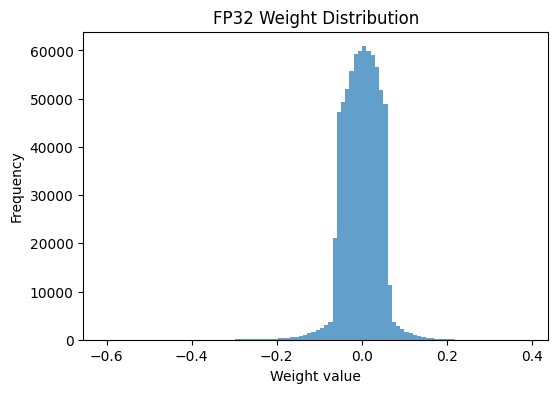

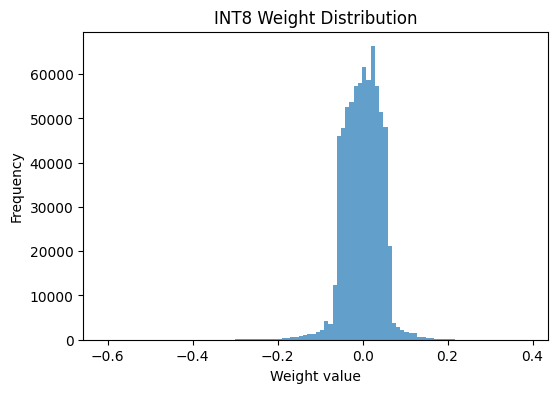

In [15]:
def plot_weight_distribution(model, title="Weights"):
    """
    Plots histogram of all weights.
    Works for FP32 and dynamic INT8 models.
    """
    weights = []

    for module in model.modules():
        # For FP32 Linear layers
        if isinstance(module, nn.Linear):
            weights.append(module.weight.detach().flatten())
        # For dynamic quantized Linear layers
        elif isinstance(module, nn.quantized.dynamic.Linear):
            # quantized weight stored in int8, convert to float
            w_int8 = module.weight().dequantize().flatten()
            weights.append(w_int8)

    if not weights:
        print(f"No weights found in model: {title}")
        return

    weights = torch.cat(weights).cpu().numpy()
    plt.figure(figsize=(6,4))
    plt.hist(weights, bins=100, alpha=0.7)
    plt.title(title)
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.show()

# Plot FP32 and INT8 weights
plot_weight_distribution(model_fp32, title="FP32 Weight Distribution")
plot_weight_distribution(quantized_model, title="INT8 Weight Distribution")


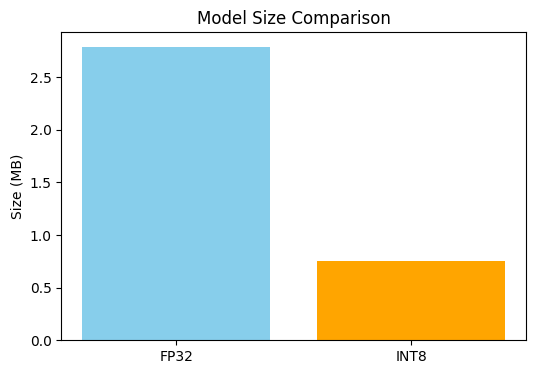

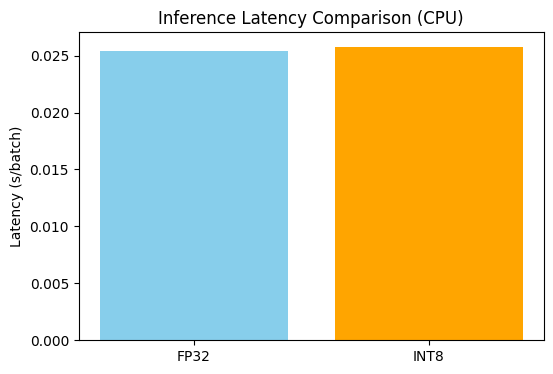

In [17]:
plt.figure(figsize=(6,4))
plt.bar(["FP32","INT8"], [fp32_size,int8_size], color=["skyblue","orange"])
plt.ylabel("Size (MB)")
plt.title("Model Size Comparison")
plt.show()

plt.figure(figsize=(6,4))
plt.bar(["FP32","INT8"], [fp32_latency,int8_latency], color=["skyblue","orange"])
plt.ylabel("Latency (s/batch)")
plt.title("Inference Latency Comparison (CPU)")
plt.show()
